In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rdflib import Graph
import sys
from tqdm import tqdm
import re


# Add the project root to Python's path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.evaluation.evaluation import KnowledgeGraphEvaluator

# Define paths
results_base_dir = os.path.join(project_root, "experiments", "results")#, "test_results")
ground_truth_dir = os.path.join(project_root, "test_data")

# Function to find ground truth file
def find_ground_truth_file(root_dir, article_id):
    """Find the ground truth file for an article"""
    # Direct path to the article directory
    article_dir = os.path.join(root_dir, article_id)
    
    if not os.path.exists(article_dir):
        return None
    
    # Look for the no_fulltext.ttl file
    ground_truth_path = os.path.join(article_dir, f"{article_id}_no_fulltext.ttl")
    
    if os.path.exists(ground_truth_path):
        return ground_truth_path
    
    # Fallback to any TTL file in the directory
    ttl_files = glob.glob(os.path.join(article_dir, "*.ttl"))
    if ttl_files:
        return ttl_files[0]
    
    return None

# Initialize evaluator
evaluator = KnowledgeGraphEvaluator()

# Results storage
results = []

# Get all article directories in results folder
article_dirs = [d for d in os.listdir(results_base_dir) 
                if os.path.isdir(os.path.join(results_base_dir, d)) and d.startswith("EU_")]

print(f"Found {len(article_dirs)} article result directories")

Found 42 article result directories


In [2]:
def clean_ttl_file(file_path):
    """Clean a TTL file by removing Markdown code block markers and other artifacts."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read()
        
        # Remove Markdown code block markers
        if '```turtle' in content or '```' in content:
            content = re.sub(r'```turtle\s*', '', content)
            content = re.sub(r'```\s*$', '', content)
            
            # Remove binary string prefixes (b'')
            content = re.sub(r"b''(\^b')?", '', content)
            
            # Save the cleaned content
            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(content)
                
            return True
        return False
    except Exception as e:
        print(f"  Error cleaning {os.path.basename(file_path)}: {str(e)}")
        return False

In [3]:
# Process each article
for article_id in tqdm(article_dirs, desc="Evaluating articles"):
    # Get article results directory
    article_results_dir = os.path.join(results_base_dir, article_id)
    
    # Find ground truth file
    ground_truth_path = find_ground_truth_file(ground_truth_dir, article_id)
    
    if not ground_truth_path:
        print(f"  Skipping {article_id}: Ground truth not found")
        break
    
    # Load ground truth graph
    ground_truth_graph = Graph()
    ground_truth_graph.parse(ground_truth_path, format="turtle")
    print(f"  Ground truth for {article_id} has {len(ground_truth_graph)} triples")
    
    # Find all turtle files for this article
    ttl_files = []
    
    # Look in article directory for TTL files
    for file in os.listdir(article_results_dir):
        file_path = os.path.join(article_results_dir, file)
        if file.endswith(".ttl") and os.path.isfile(file_path):
            ttl_files.append(file_path)
    
    if not ttl_files:
        print(f"  Skipping {article_id}: No TTL files found in {article_results_dir}")
        # Debug: List the files that are present
        print(f"  Files in directory: {os.listdir(article_results_dir)}")
        continue
    
    print(f"  Found {len(ttl_files)} TTL files for {article_id}")
    
    # Evaluate each file
    for ttl_file in ttl_files:
        file_name = os.path.basename(ttl_file)
        
        # Extract strategy from the filename
        # Expected pattern: {celex}_{model}_{strategy}_{timestamp}.ttl
        parts = file_name.split('_')
        
        # Try to identify the strategy from the filename parts
        strategy_name = None
        model_name = None

        for part in parts:
            if part in ["zero-shot", "one-shot", "few-shot"]:
                strategy_name = part
                break

        if len(parts) >= 3:
            model_name = parts[1]
        
        if not strategy_name:
            print(f"  Skipping {file_name}: Unable to determine strategy")
            continue

        if not model_name:
            print(f"  Using 'unknown' as model name for {file_name}")
            model_name = "unknown"
        
        print(f"  Evaluating: {file_name} (model: {model_name}, strategy: {strategy_name})")

        # Add this before trying to parse the TTL file
        cleaned = clean_ttl_file(ttl_file)
        if cleaned:
            print(f"  Cleaned Markdown artifacts from {os.path.basename(ttl_file)}")
        
        # Load the generated graph
        try:
            generated_graph = Graph()
            generated_graph.parse(ttl_file, format="turtle")
            print(f"  Generated graph has {len(generated_graph)} triples")
            
            # Run comprehensive evaluation
            metrics = evaluator.evaluate_comprehensive(generated_graph, ground_truth_graph)
            
            # Store results with article metadata
            metrics["article_id"] = article_id
            metrics["model"] = model_name
            metrics["strategy"] = strategy_name
            metrics["file_name"] = file_name
            metrics["triple_count"] = len(generated_graph)
            metrics["ground_truth_triple_count"] = len(ground_truth_graph)
            
            results.append(metrics)
        except Exception as e:
            print(f"  Error evaluating {file_name}: {str(e)}")

# Create results dataframe
results_df = pd.DataFrame(results)
print(f"Completed evaluation of {len(results)} files")

Evaluating articles:  14%|█▍        | 6/42 [00:00<00:00, 59.56it/s]

  Ground truth for EU_32012L0027_Title_0_Chapter_3_Section_0_Article_14 has 35 triples
  Found 9 TTL files for EU_32012L0027_Title_0_Chapter_3_Section_0_Article_14
  Evaluating: 32012L0027_gpt-4o-2024-08-06_few-shot_20250409_111638.ttl (model: gpt-4o-2024-08-06, strategy: few-shot)
  Generated graph has 42 triples
  Evaluating: 32012L0027_llama3.1:70b_one-shot_20250410_001727.ttl (model: llama3.1:70b, strategy: one-shot)
  Error evaluating 32012L0027_llama3.1:70b_one-shot_20250410_001727.ttl: at line 1 of <>:
Bad syntax (expected directive or statement) at ^ in:
"b''^b'turtle\n@prefix owl: <http://www.w3.org/2002/07/owl#> .\n@pref'..."
  Evaluating: 32012L0027_gpt-4o-2024-08-06_one-shot_20250409_111621.ttl (model: gpt-4o-2024-08-06, strategy: one-shot)
  Generated graph has 31 triples
  Evaluating: 32012L0027_llama3.1:70b_zero-shot_20250410_001611.ttl (model: llama3.1:70b, strategy: zero-shot)
  Generated graph has 28 triples
  Evaluating: 32012L0027_o3-mini-2025-01-31_zero-shot_202504

Evaluating articles:  29%|██▊       | 12/42 [00:00<00:00, 53.73it/s]

  Generated graph has 19 triples
  Evaluating: 32018R1999_llama3.1:70b_few-shot_20250409_222303.ttl (model: llama3.1:70b, strategy: few-shot)
  Error evaluating 32018R1999_llama3.1:70b_few-shot_20250409_222303.ttl: at line 32 of <>:
Bad syntax (objectList expected) at ^ in:
"...b'ss report.\n    """ ;\n    dct:annotator [\n        foaf:Person'^b' ;\n        foaf:name "A"\n    ] ,\n    [\n        foaf:Person ;'..."
  Evaluating: 32018R1999_o3-mini-2025-01-31_zero-shot_20250410_231557.ttl (model: o3-mini-2025-01-31, strategy: zero-shot)
  Error evaluating 32018R1999_o3-mini-2025-01-31_zero-shot_20250410_231557.ttl: at line 11 of <>:
Bad syntax (newline found in string literal) at ^ in:
"...b'apter_2_Section_0_Article_14" ;\n    rdfs:comment "article 14'^b'\nupdate of the integrated national energy and climate plan\n1'..."
  Evaluating: 32018R1999_o3-mini-2025-01-31_few-shot_20250410_231637.ttl (model: o3-mini-2025-01-31, strategy: few-shot)
  Generated graph has 12 triples
  Evaluating: 

Evaluating articles:  45%|████▌     | 19/42 [00:00<00:00, 57.48it/s]

  Generated graph has 16 triples
  Evaluating: 32018R1999_gpt-4o-2024-08-06_one-shot_20250409_112436.ttl (model: gpt-4o-2024-08-06, strategy: one-shot)
  Generated graph has 28 triples
  Evaluating: 32018R1999_gpt-4o-2024-08-06_zero-shot_20250409_112430.ttl (model: gpt-4o-2024-08-06, strategy: zero-shot)
  Generated graph has 18 triples
  Evaluating: 32018R1999_llama3.1:70b_few-shot_20250409_232333.ttl (model: llama3.1:70b, strategy: few-shot)
  Generated graph has 32 triples
  Evaluating: 32018R1999_o3-mini-2025-01-31_one-shot_20250410_232643.ttl (model: o3-mini-2025-01-31, strategy: one-shot)
  Generated graph has 15 triples
  Evaluating: 32018R1999_o3-mini-2025-01-31_zero-shot_20250410_232617.ttl (model: o3-mini-2025-01-31, strategy: zero-shot)
  Generated graph has 3 triples
  Ground truth for EU_32014R0421_Title_0_Chapter_0_Section_0_Article_01 has 60 triples
  Found 9 TTL files for EU_32014R0421_Title_0_Chapter_0_Section_0_Article_01
  Evaluating: 32014R0421_gpt-4o-2024-08-06_few

Evaluating articles:  60%|█████▉    | 25/42 [00:00<00:00, 49.80it/s]

  Generated graph has 45 triples
  Evaluating: 32014L0094_llama3.1:70b_zero-shot_20250409_233057.ttl (model: llama3.1:70b, strategy: zero-shot)
  Generated graph has 22 triples
  Evaluating: 32014L0094_gpt-4o-2024-08-06_zero-shot_20250409_112556.ttl (model: gpt-4o-2024-08-06, strategy: zero-shot)
  Generated graph has 29 triples
  Evaluating: 32014L0094_gpt-4o-2024-08-06_few-shot_20250409_112615.ttl (model: gpt-4o-2024-08-06, strategy: few-shot)
  Generated graph has 45 triples
  Evaluating: 32014L0094_o3-mini-2025-01-31_few-shot_20250410_233209.ttl (model: o3-mini-2025-01-31, strategy: few-shot)
  Generated graph has 27 triples
  Evaluating: 32014L0094_o3-mini-2025-01-31_zero-shot_20250410_233115.ttl (model: o3-mini-2025-01-31, strategy: zero-shot)
  Generated graph has 7 triples
  Ground truth for EU_32009R0079_Title_0_Chapter_0_Section_0_Article_16 has 20 triples
  Found 9 TTL files for EU_32009R0079_Title_0_Chapter_0_Section_0_Article_16
  Evaluating: 32009R0079_gpt-4o-2024-08-06_z

Evaluating articles:  74%|███████▍  | 31/42 [00:00<00:00, 51.72it/s]

  Error evaluating 32019R0631_llama3.1:70b_one-shot_20250409_222918.ttl: at line 49 of <>:
Bad syntax (expected directive or statement) at ^ in:
"...b'poli:EU_32019R0631_Title_0_Chapter_0_Section_0_Article_01 .\n'^b'.'"
  Evaluating: 32019R0631_o3-mini-2025-01-31_few-shot_20250410_234138.ttl (model: o3-mini-2025-01-31, strategy: few-shot)
  Generated graph has 35 triples
  Evaluating: 32019R0631_gpt-4o-2024-08-06_one-shot_20250409_112827.ttl (model: gpt-4o-2024-08-06, strategy: one-shot)
  Generated graph has 31 triples
  Evaluating: 32019R0631_gpt-4o-2024-08-06_zero-shot_20250409_112816.ttl (model: gpt-4o-2024-08-06, strategy: zero-shot)
  Generated graph has 37 triples
  Ground truth for EU_32004L0008_Title_0_Chapter_0_Section_0_Article_11 has 26 triples
  Found 9 TTL files for EU_32004L0008_Title_0_Chapter_0_Section_0_Article_11
  Evaluating: 32004L0008_llama3.1:70b_one-shot_20250409_232836.ttl (model: llama3.1:70b, strategy: one-shot)
  Generated graph has 33 triples
  Evaluating: 

Evaluating articles: 100%|██████████| 42/42 [00:00<00:00, 50.92it/s]

  Generated graph has 17 triples
  Evaluating: 32018L2001_llama3.1:70b_zero-shot_20250409_221341.ttl (model: llama3.1:70b, strategy: zero-shot)
  Error evaluating 32018L2001_llama3.1:70b_zero-shot_20250409_221341.ttl: at line 1 of <>:
Bad syntax (expected directive or statement) at ^ in:
"b''^b'turtle\n@prefix : <http://purl.org/poliana#> .\n@prefix dct: <'..."
  Evaluating: 32018L2001_gpt-4o-2024-08-06_one-shot_20250409_113440.ttl (model: gpt-4o-2024-08-06, strategy: one-shot)
  Generated graph has 25 triples
  Evaluating: 32018L2001_gpt-4o-2024-08-06_zero-shot_20250409_113433.ttl (model: gpt-4o-2024-08-06, strategy: zero-shot)
  Generated graph has 41 triples
  Ground truth for EU_32019R0631_Title_0_Chapter_0_Section_0_Article_14 has 43 triples
  Found 9 TTL files for EU_32019R0631_Title_0_Chapter_0_Section_0_Article_14
  Evaluating: 32019R0631_gpt-4o-2024-08-06_one-shot_20250409_113507.ttl (model: gpt-4o-2024-08-06, strategy: one-shot)
  Generated graph has 36 triples
  Evaluating: 

In [4]:
results_df[["model", "true_positives"]]

,model,true_positives
0,gpt-4o-2024-08-06,16
1,gpt-4o-2024-08-06,14
2,llama3.1:70b,0
3,o3-mini-2025-01-31,1
4,gpt-4o-2024-08-06,10
...,...,...
278,o3-mini-2025-01-31,1
279,llama3.1:70b,0
280,gpt-4o-2024-08-06,6
281,o3-mini-2025-01-31,3


In [5]:
results_df.columns

Index(['is_valid', 'syntax_errors', 'precision', 'recall', 'f1_score',
       'true_positives', 'false_positives', 'false_negatives',
       'property_precision', 'property_recall', 'property_f1_score',
       'property_true_positives', 'property_false_positives',
       'property_false_negatives', 'property_diversity', 'class_precision',
       'class_recall', 'class_f1_score', 'class_true_positives',
       'class_false_positives', 'class_false_negatives',
       'https://polianna-kg.org/Ontology#contains_instrument',
       'https://polianna-kg.org/Ontology#contains_objective',
       'https://polianna-kg.org/Ontology#contains_monitoring_form',
       'https://polianna-kg.org/Ontology#contains_sanctioning_form',
       'https://polianna-kg.org/Ontology#addresses', 'entity_precision',
       'entity_recall', 'entity_f1_score', 'entity_true_positives',
       'entity_false_positives', 'entity_false_negatives',
       'ontology_validation', 'ground_truth_triple_count', 'article_id',
  

In [6]:
# how me all results where "is valid" is true 
valid_results = results_df[results_df["is_valid"] == True]

In [7]:
# Save results to CSV
# results_path = os.path.join(project_root, "experiments", "results", "all_evaluation_results.csv")
# results_df.to_csv(results_path, index=False)
# print(f"Results saved to {results_path}")

In [8]:
# If we have results, display summary
if len(results) > 0:
    # Group by strategy and model
    strategy_summary = results_df.groupby(['strategy', 'model']).agg({
        'precision': 'mean',
        'recall': 'mean',
        'f1_score': 'mean',
        'article_id': 'count'  # Count of evaluations per strategy
    }).rename(columns={'article_id': 'count'}).reset_index()
    
    print("\nStrategy Summary:")
    display(strategy_summary)
else:
    print("No evaluation results to display")


Strategy Summary:


,strategy,model,precision,recall,f1_score,count
0,few-shot,gpt-4o-2024-08-06,0.474573,0.377656,0.405874,42
1,few-shot,llama3.1:70b,0.000000,0.000000,0.000000,20
2,few-shot,o3-mini-2025-01-31,0.446963,0.208552,0.271630,36
3,one-shot,gpt-4o-2024-08-06,0.465668,0.393680,0.416823,42
4,one-shot,llama3.1:70b,0.000000,0.000000,0.000000,19
5,one-shot,o3-mini-2025-01-31,0.420980,0.211287,0.264463,37
6,zero-shot,gpt-4o-2024-08-06,0.199346,0.140317,0.155733,41
7,zero-shot,llama3.1:70b,0.000000,0.000000,0.000000,17
8,zero-shot,o3-mini-2025-01-31,0.139527,0.024672,0.038157,29



Model and Strategy Combined Summary:

,model,strategy,precision,recall,f1_score,entity_precision,entity_recall,entity_f1_score,triple_count,count
0,gpt-4o-2024-08-06,few-shot,0.474573,0.377656,0.405874,0.616074,0.523117,0.540730,29.428571,42
1,gpt-4o-2024-08-06,one-shot,0.465668,0.393680,0.416823,0.615161,0.486382,0.524304,30.571429,42
2,gpt-4o-2024-08-06,zero-shot,0.199346,0.140317,0.155733,0.895122,0.116014,0.200135,25.121951,41
3,llama3.1:70b,few-shot,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,27.350000,20
4,llama3.1:70b,one-shot,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.789474,19
5,llama3.1:70b,zero-shot,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.470588,17
6,o3-mini-2025-01-31,few-shot,0.446963,0.208552,0.271630,0.667270,0.411472,0.487651,17.361111,36
7,o3-mini-2025-01-31,one-shot,0.420980,0.211287,0.264463,0.648593,0.382550,0.455431,18.243243,37
8,o3-mini-2025-01-31,zero-shot,0.139527,0.024672,0.038157,0.706076,0.094553,0.152537,6.586207,29


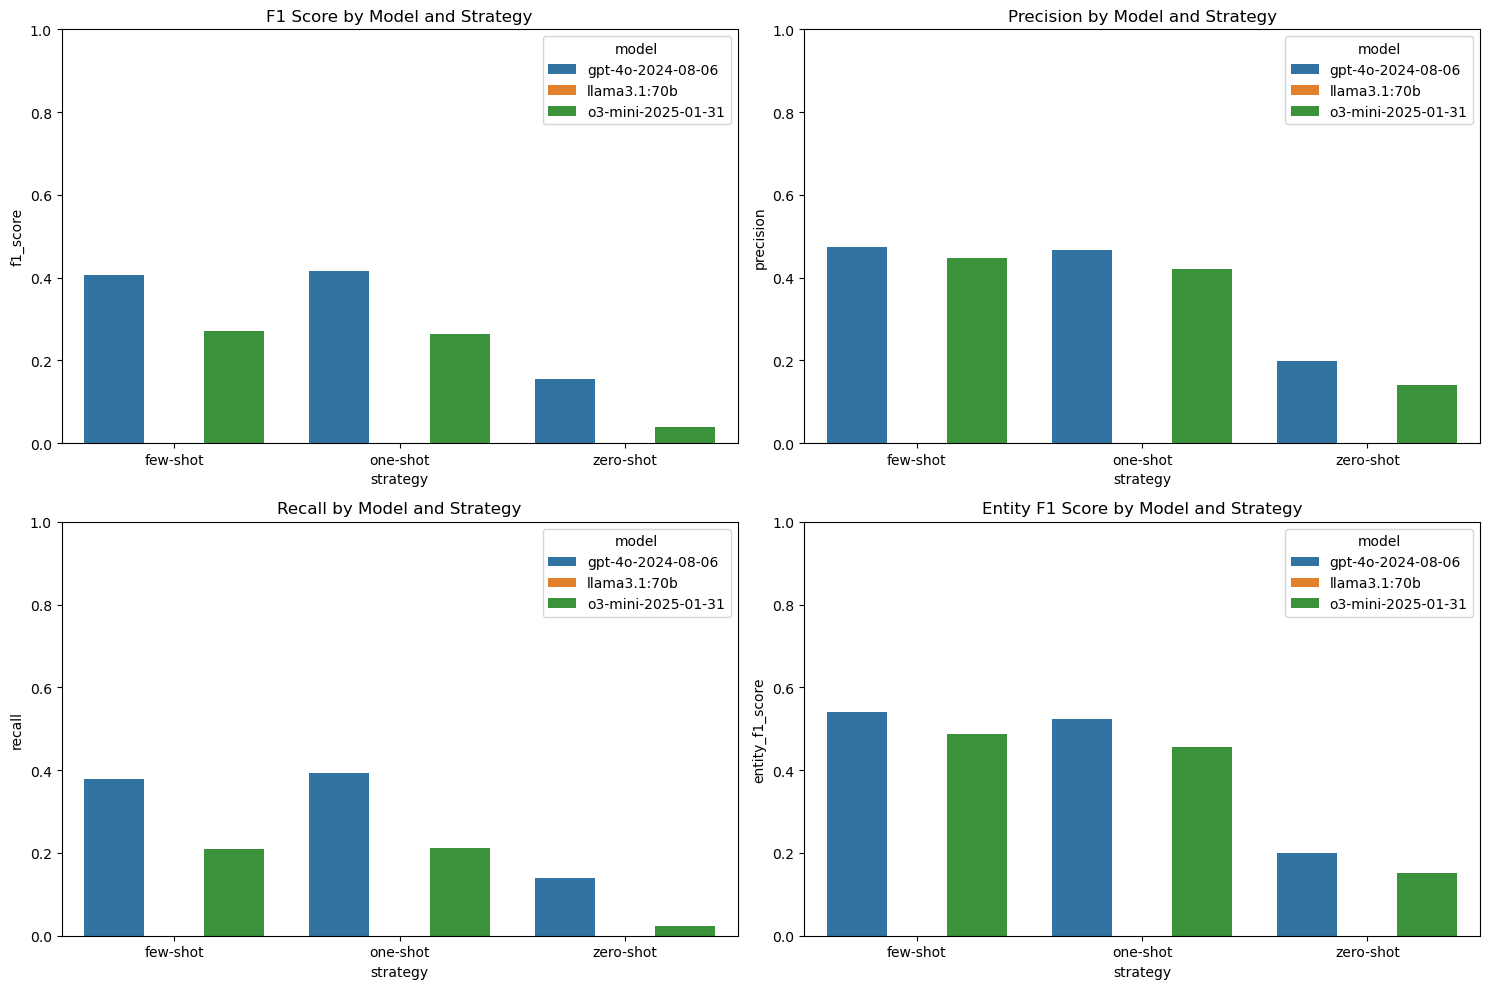

In [9]:
# Create a multi-level summary by model and strategy
model_strategy_summary = results_df.groupby(['model', 'strategy']).agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1_score': 'mean',
    'entity_precision': 'mean',
    'entity_recall': 'mean',
    'entity_f1_score': 'mean',
    'triple_count': 'mean',
    'article_id': 'count'  # Count of evaluations per combination
}).rename(columns={'article_id': 'count'}).reset_index()

print("\nModel and Strategy Combined Summary:")
display(model_strategy_summary)

# Create comparison visualizations
plt.figure(figsize=(15, 10))

# Plot F1 scores by model and strategy
plt.subplot(2, 2, 1)
sns.barplot(x='strategy', y='f1_score', hue='model', data=model_strategy_summary)
plt.title('F1 Score by Model and Strategy')
plt.ylim(0, 1)

# Plot Precision by model and strategy
plt.subplot(2, 2, 2)
sns.barplot(x='strategy', y='precision', hue='model', data=model_strategy_summary)
plt.title('Precision by Model and Strategy')
plt.ylim(0, 1)

# Plot Recall by model and strategy
plt.subplot(2, 2, 3)
sns.barplot(x='strategy', y='recall', hue='model', data=model_strategy_summary)
plt.title('Recall by Model and Strategy')
plt.ylim(0, 1)

# Plot Entity F1 by model and strategy
plt.subplot(2, 2, 4)
sns.barplot(x='strategy', y='entity_f1_score', hue='model', data=model_strategy_summary)
plt.title('Entity F1 Score by Model and Strategy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


Model Summary (across all strategies):


,model,precision,recall,f1_score,entity_precision,entity_recall,entity_f1_score,triple_count,count
0,gpt-4o-2024-08-06,0.381307,0.305193,0.327507,0.707295,0.377245,0.423495,28.400000,125
1,llama3.1:70b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.357143,56
2,o3-mini-2025-01-31,0.350130,0.157264,0.202651,0.671528,0.310876,0.380686,14.617647,102


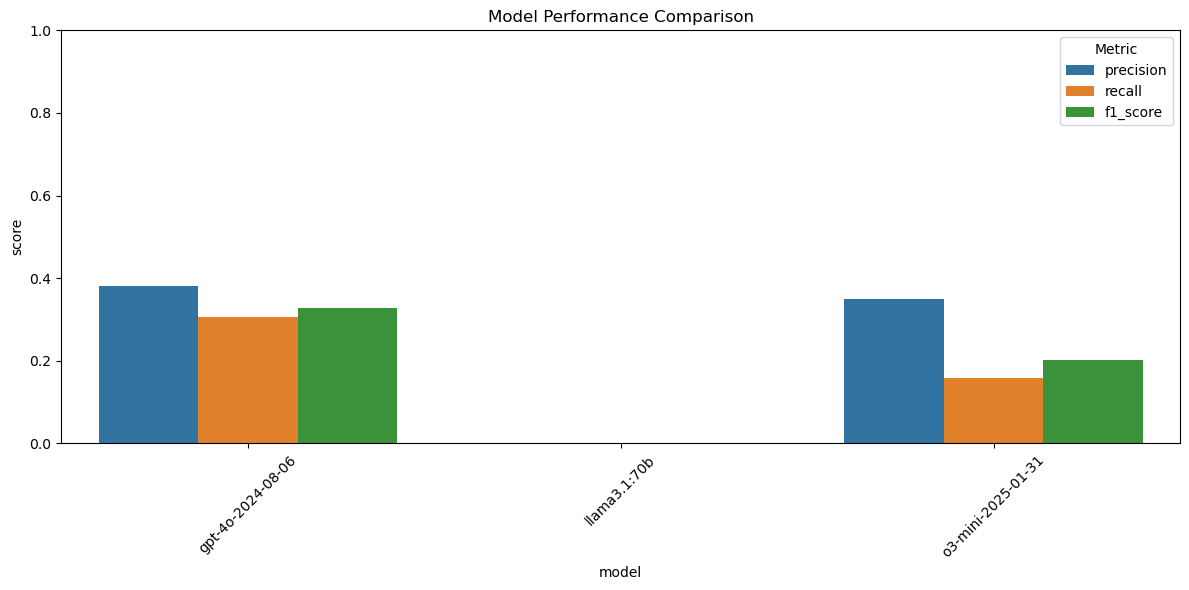

In [10]:
# Create a model summary (across all strategies)
model_summary = results_df.groupby('model').agg({
    'precision': 'mean',
    'recall': 'mean',
    'f1_score': 'mean',
    'entity_precision': 'mean',
    'entity_recall': 'mean',
    'entity_f1_score': 'mean',
    'triple_count': 'mean',
    'article_id': 'count'  # Count of evaluations per model
}).rename(columns={'article_id': 'count'}).reset_index()

print("\nModel Summary (across all strategies):")
display(model_summary)

# Create model comparison visualization
plt.figure(figsize=(12, 6))
metrics_to_compare = ['precision', 'recall', 'f1_score']
model_metrics = pd.melt(
    model_summary,
    id_vars=['model'],
    value_vars=metrics_to_compare,
    var_name='metric',
    value_name='score'
)

sns.barplot(x='model', y='score', hue='metric', data=model_metrics)
plt.title('Model Performance Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()